In [1]:
import jax
#import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from tqdm import tqdm
from src.helpers import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


### 2 times IWP

In [2]:
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
Q = lambda h: np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])

In [3]:
#function that samples q-times IWP path
def sample_IWP_path(q, N, h, y0=None):

    mu_0 = np.zeros(q)
    Sigma_0 = np.eye(q)
    if y0 != None:
        mu_0[0] = y0
        Sigma_0[0,0] = 0
    x = np.zeros((N, q))
    x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x



#function that samples q-times IWP path
def sample_IWP_path_from_taylor_modes(q, N, h, x_0):

    x = np.zeros((N, q))
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x


In [4]:
np.random.seed(42)

t0, t1 = 0.0, 10.0
N = 222
ts = np.linspace(t0, t1, num=N, endpoint=True)
h = (t1 - t0) / N

#x1 = sample_IWP_path(3, N, h)
#x2 = sample_IWP_path(3, N, h)
#x3 = sample_IWP_path(3, N, h)
#x4 = sample_IWP_path(3, N, h)
#x5 = sample_IWP_path(3, N, h)

x1 = sample_IWP_path(3, N, h, y0=-3)
x2 = sample_IWP_path(3, N, h, y0=-3)
x3 = sample_IWP_path(3, N, h, y0=-3)
x4 = sample_IWP_path(3, N, h, y0=-3)
x5 = sample_IWP_path(3, N, h, y0=-3)

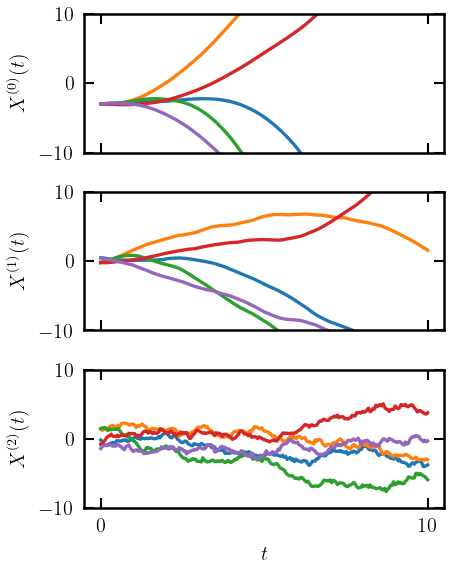

In [5]:
# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

#plt.savefig('2-times-IWP.png')
plt.show()
plt.close()   

### Exp 1: Logistic ODE


$$ \dot{x} = x * (1 - x), \quad x_0 = 0.01$$

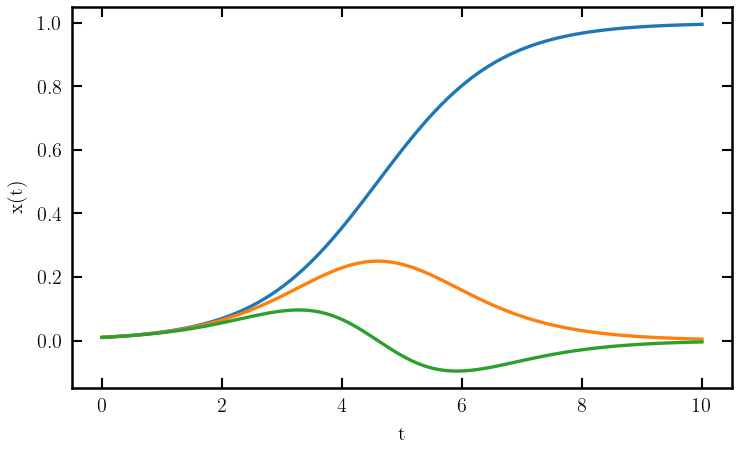

In [6]:
vf = lambda x: x*(1-x)
#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))

t0, t1 = 0.0, 10.0
N = 22
ts = np.linspace(t0, t1, num=N, endpoint=True)
t = np.linspace(t0, t1, 100, endpoint=True) #for visualization purpose exact solution
h = (t1 - t0) / N


plt.plot(t, x_exact(t), label='Exact Solution')
plt.plot(t, x_prime_exact(t))
plt.plot(t, x_prime_prime_exact(t))

plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [7]:
#initial value
y0 = 0.01
# initialize X(0) via the taylor coefficients
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])

In [8]:
print(X_0[2]) 
print("this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:")
#autodiff of vf
vf_autodiff = jax.grad(vf)
print(vf(y0) * vf_autodiff(y0))

0.009702
this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:
0.009702


#### 1.1 Prior with correct Initialization

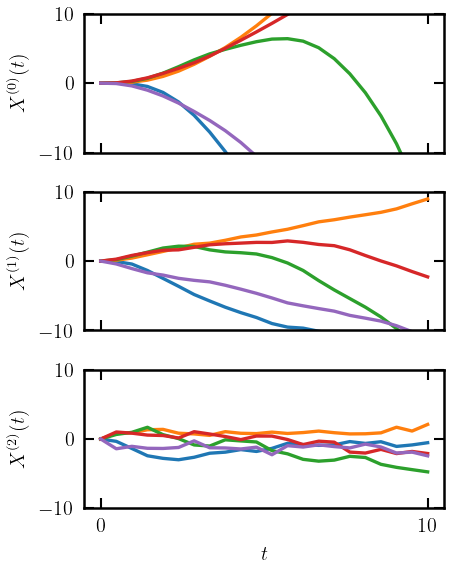

In [9]:
np.random.seed(42)

x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])
#plt.savefig('2-times-IWP.png')

#### 1.2 Measurement Model

In [10]:
E_0 = np.array([[1,0,0]])
E_1 = np.array([[0,1,0]])
R = np.array([[0.22]])

g = lambda X: X[1] - vf(X[0])
jacobian_g = jacobian(g)

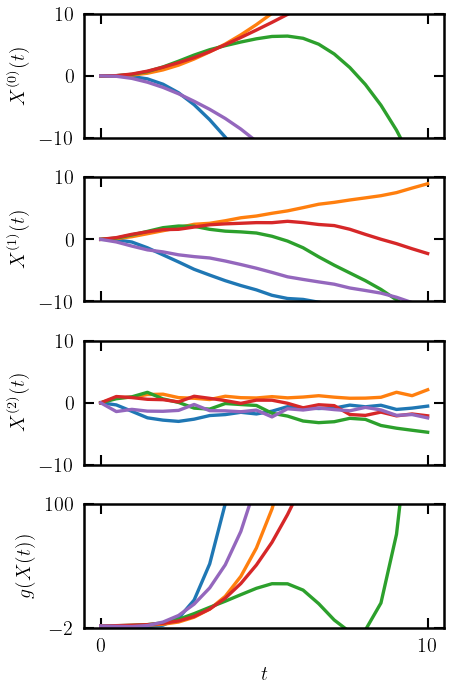

In [11]:
np.random.seed(42)

x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(4, 1, figsize=(4, 6))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])


    axs[i].set_xticks([0, 10])
    axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

axs[3].set_ylabel(f'$g(X(t))$')
axs[3].set_ylim(-2, 100)
axs[3].set_yticks([-2, 100])
axs[3].set_xlabel('$t$')
axs[3].set_xticks([0, 10])
axs[3].plot(ts, g(x1.T))
axs[3].plot(ts, g(x2.T))
axs[3].plot(ts, g(x3.T))
axs[3].plot(ts, g(x4.T))
axs[3].plot(ts, g(x5.T))
#plt.savefig('2-times-IWP.png')

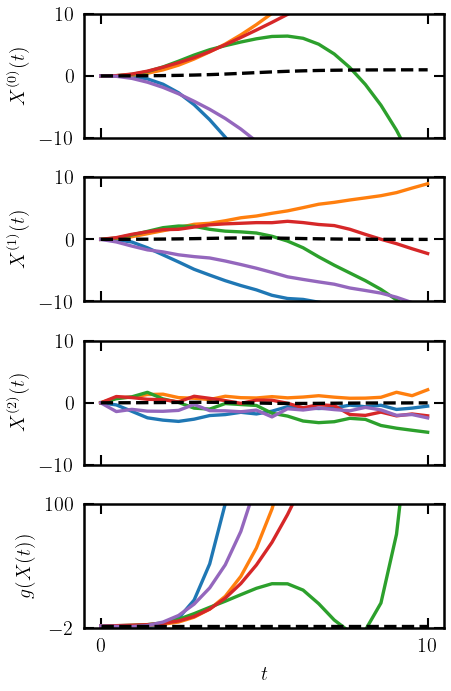

In [12]:
np.random.seed(42)

x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(4, 1, figsize=(4, 6))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])


    axs[i].set_xticks([0, 10])
    axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

axs[3].set_ylabel(f'$g(X(t))$')
axs[3].set_ylim(-2, 100)
axs[3].set_yticks([-2, 100])
axs[3].set_xlabel('$t$')
axs[3].set_xticks([0, 10])
axs[3].plot(ts, g(x1.T))
axs[3].plot(ts, g(x2.T))
axs[3].plot(ts, g(x3.T))
axs[3].plot(ts, g(x4.T))
axs[3].plot(ts, g(x5.T))
#plt.savefig('2-times-IWP.png')

#add "ground truth"
axs[0].plot(ts, x_exact(ts), color="black", linestyle='--', label="ground truth")
axs[1].plot(ts, x_prime_exact(ts), color="black", linestyle='--', label="ground truth")
axs[2].plot(ts, x_prime_prime_exact(ts), color="black", linestyle='--', label="ground truth")
axs[3].plot(ts, x_prime_exact(ts) - x_exact(ts)*(1-x_exact(ts)), color="black", linestyle='--', label="ground truth")

#### 1.3 Define Observed data

In [13]:
z_sequence = np.zeros(N)

In [14]:
print(h)
mu_0 = X_0
Sigma_0 = np.eye(3)*0

A_h = A(h)
Q_h = Q(h)
R_h = np.array([[0.0]])

print(mu_0.shape, Sigma_0.shape)
print(A_h.shape, Q_h.shape)


0.45454545454545453
(3,) (3, 3)
(3, 3) (3, 3)


In [15]:
print(z_sequence.shape)
print(ts.shape)

(22,)
(22,)


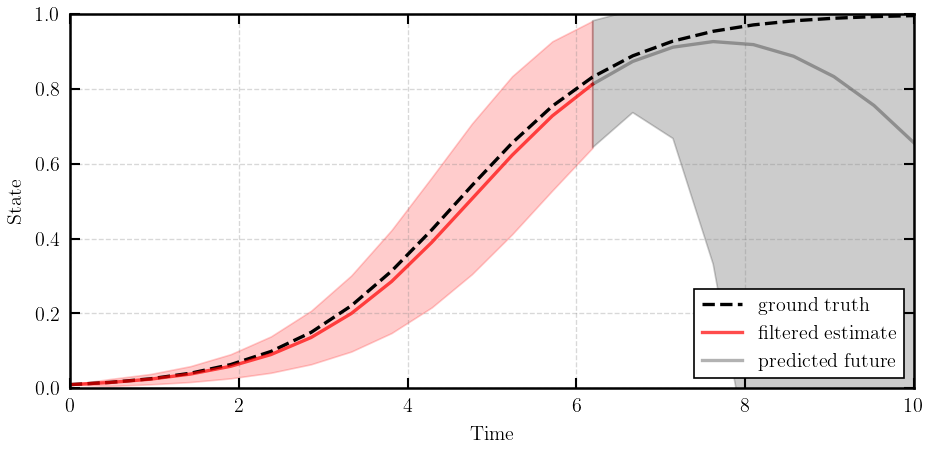

In [16]:
step = 13
m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(step, N, mu_0, Sigma_0, A_h, Q_h, R_h, z_sequence, g, jacobian_g)
plot_kalman_filter(step, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_exact(ts), x_lim=[0,10], y_lim = [0,1], loc_pos='lower right')

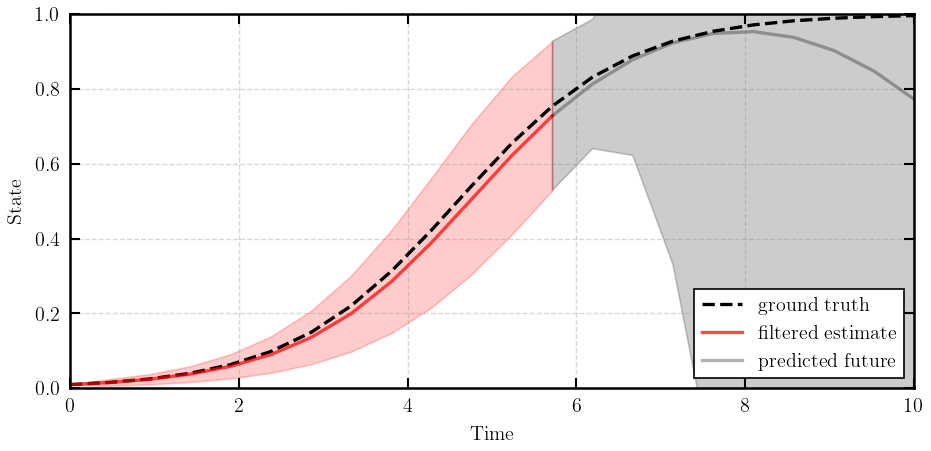

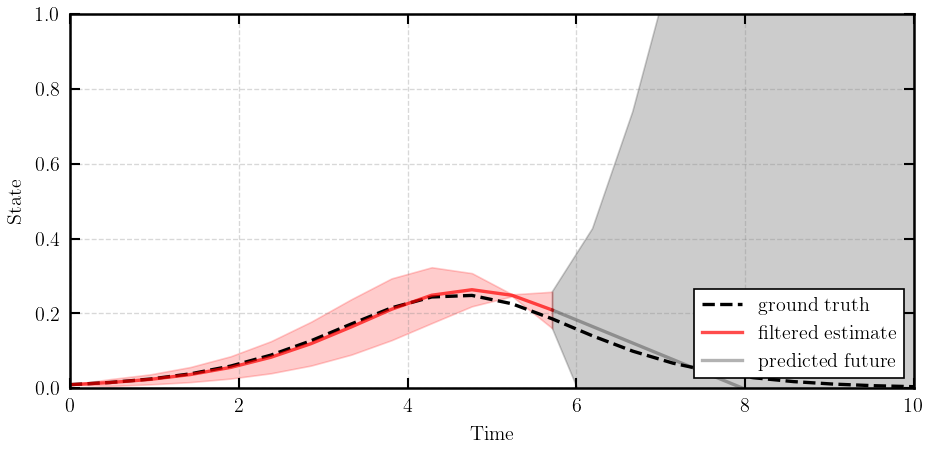

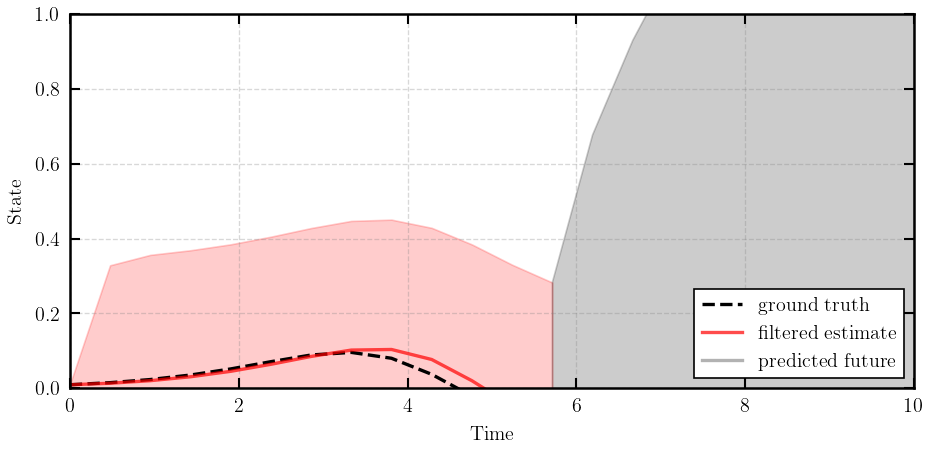

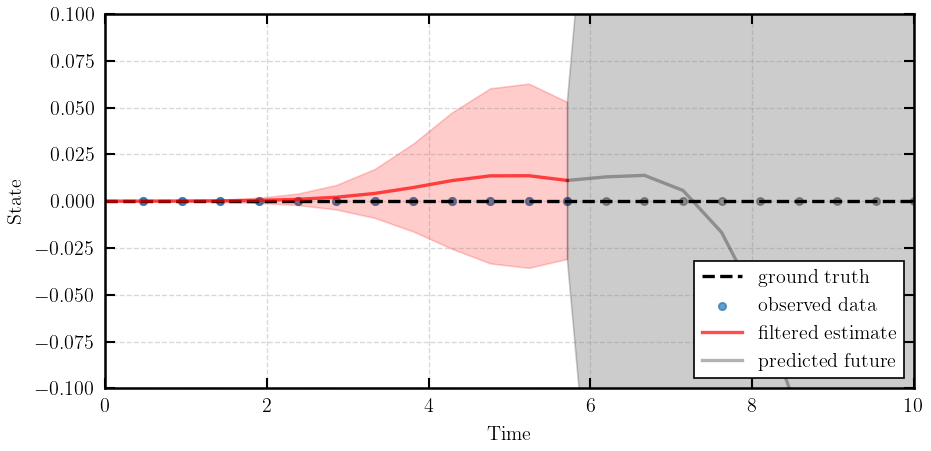

In [17]:
step = 12
m_filtered, P_filtered, m_predicted, P_predicted = extended_kalman_filter_full(step, N, mu_0, Sigma_0, A_h, Q_h, R_h, z_sequence, g, jacobian_g)

exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

for i in range(3):
    plot_kalman_filter(step, ts, m_filtered[:,i], P_filtered[:,i,i], m_predicted[:,i], P_predicted[:,i,i], x_sequence=exact_sols[i](ts), x_lim=[0,10], y_lim = [0,1], loc_pos='lower right')

z_filtered = m_filtered[:,1] - m_filtered[:,0]*(1 - m_filtered[:,0])
z_pred = m_predicted[:,1] - m_predicted[:,0]*(1 - m_predicted[:,0])

z_filtered_uncertainty = []
for i in range(len(m_filtered)):
    z_filtered_uncertainty.append(jacobian_g(m_filtered[i,:])@P_filtered[i,:]@jacobian_g(m_filtered[i,:]).T)

z_filtered_uncertainty = np.array(z_filtered_uncertainty)

z_pred_uncertainty = []
for i in range(len(m_predicted)):
    z_pred_uncertainty.append(jacobian_g(m_predicted[i,:])@P_predicted[i,:]@jacobian_g(m_predicted[i,:]).T)

z_pred_uncertainty = np.array(z_pred_uncertainty)


plot_kalman_filter(step, ts, z_filtered, z_filtered_uncertainty, z_pred, z_pred_uncertainty, x_sequence=np.zeros_like(ts), z_sequence=z_sequence[1:], x_lim=[0,10], y_lim = [-0.1,0.1], loc_pos='lower right')




In [18]:
#function that plots the full ODE-Filter output!

In [ ]:
def plot_generator_kalman_filter(
    t, ts, m_projected, P_projected, m_future_projected, P_future_projected,
    x_sequence=None, z_sequence=None, savefig=False, path="filter_imgs",
    x_lim=None, y_lim=None, loc_pos='upper right', ax=None
):
    """
    Plot Kalman filter results. If ax is provided, plot on that axis and return it.
    Otherwise, create a new figure and axis, plot, and return the axis.
    """


    # If no axis is provided, create one
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        created_fig = True

    # plot the ground truth if given
    if x_sequence is not None:
        ax.plot(ts, x_sequence, label='ground truth', color='black', linestyle='--')
    # plot the observed data if given
    if z_sequence is not None:
        ax.scatter(ts[1:], z_sequence, color='black', s=20, alpha=0.3)
        ax.scatter(ts[1:t+1], z_sequence[:t], s=20, alpha=0.7, label='observed data')

    # plot the filtered estimate projected to one dimension
    ax.plot(ts[:t+1], m_projected, color='red', alpha=0.7, label='filtered estimate')
    
    ax.fill_between(ts[:t+1], m_projected - np.sqrt(P_projected), m_projected + np.sqrt(P_projected), color='red', alpha=0.2)

    ax.plot(ts[t:], m_future_projected, color='black', alpha=0.3, label='predicted future')
    ax.fill_between(ts[t:], m_future_projected - np.sqrt(P_future_projected), m_future_projected + np.sqrt(P_future_projected), color='black', alpha=0.2)

    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    if loc_pos is not None:
        ax.legend(loc=loc_pos)
    ax.grid(True)

    if savefig and created_fig:
        fig.savefig(path + f'/kalman_filter_{t}.png')
        plt.close(fig)
    elif created_fig:
        plt.show()
        plt.close(fig)

    return ax

In [28]:
def plot_kalman_filter_subplots(step, savefig="False"):
    """
    Plot Kalman filter results for all 4 components in a 4x1 subplot layout.
    
    Args:
        step: Current time step for the filter
    """
    m_filtered, P_filtered, m_predicted, P_predicted = extended_kalman_filter_full(step, N, mu_0, Sigma_0, A_h, Q_h, R_h, z_sequence, g, jacobian_g)

    if step == 0:
        m_filtered = m_filtered.reshape(1, -1)
        P_filtered = P_filtered.reshape(1, *P_filtered.shape)

    if step == N-1:
        m_predicted = m_predicted.reshape(1, -1)
        P_predicted = P_predicted.reshape(1, *P_predicted.shape)

    exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

    # Create a 4x1 subplot figure
    fig, axs = plt.subplots(4, 1, figsize=(8, 12))

    # Plot the first 3 components using plot_generator_kalman_filter
    for i in range(3):
        plot_generator_kalman_filter(
            step, ts, m_filtered[:,i], P_filtered[:,i,i], m_predicted[:,i], P_predicted[:,i,i], 
            x_sequence=exact_sols[i](ts), x_lim=[0,10], y_lim=[0,1], loc_pos=None, ax=axs[i]
        )
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        # Remove x-tick labels and x-axis label for upper subplots (keep the ticks)
        axs[i].set_xticklabels([])
        axs[i].set_xticks([0,10])
        axs[i].set_xlabel('')
        # Disable grid
        axs[i].grid(False)

    # Calculate z values and uncertainties
    z_filtered = m_filtered[:,1] - m_filtered[:,0]*(1 - m_filtered[:,0])
    z_pred = m_predicted[:,1] - m_predicted[:,0]*(1 - m_predicted[:,0])

    z_filtered_uncertainty = []
    for i in range(len(m_filtered)):
        z_filtered_uncertainty.append(jacobian_g(m_filtered[i,:])@P_filtered[i,:]@jacobian_g(m_filtered[i,:]).T)

    z_filtered_uncertainty = np.array(z_filtered_uncertainty)

    z_pred_uncertainty = []
    for i in range(len(m_predicted)):
        z_pred_uncertainty.append(jacobian_g(m_predicted[i,:])@P_predicted[i,:]@jacobian_g(m_predicted[i,:]).T)

    z_pred_uncertainty = np.array(z_pred_uncertainty)

    # Plot the 4th subplot (z values) using plot_generator_kalman_filter
    plot_generator_kalman_filter(
        step, ts, z_filtered, z_filtered_uncertainty, z_pred, z_pred_uncertainty, 
        x_sequence=np.zeros_like(ts), z_sequence=z_sequence[1:], x_lim=[0,10], y_lim=[-0.1,0.1], 
        loc_pos='lower left', ax=axs[3]
    )
    axs[3].set_ylabel('$g(X(t))$')
    axs[3].set_xlabel('Time')
    # Disable grid for the last subplot
    axs[3].grid(False)
    axs[3].set_xticks([0,10])
    axs[3].set_yticks([-0.1, 0, 0.1])

    axs[0].set_ylim([0,1])
    axs[0].set_yticks([0,1])

    axs[1].set_ylim([0,0.4])
    axs[1].set_yticks([0,0.4])

    axs[2].set_ylim([-0.4,0.4])
    axs[2].set_yticks([-0.2, 0.2])

    plt.tight_layout()
    if savefig==True:
        plt.savefig(f"logistic_imgs/img_{step}.png")
        plt.close()
    else:
        plt.show()

In [29]:
# Example usage
plot_kalman_filter_subplots(12, savefig=True)

(13,) (13,)
(13,) (13,)
(13,) (13,)
(13,) (13,)


In [30]:
m_projected.shape

(14,)

(22,) (22,)
(22,) (22,)
(22,) (22,)
(22,) (22,)


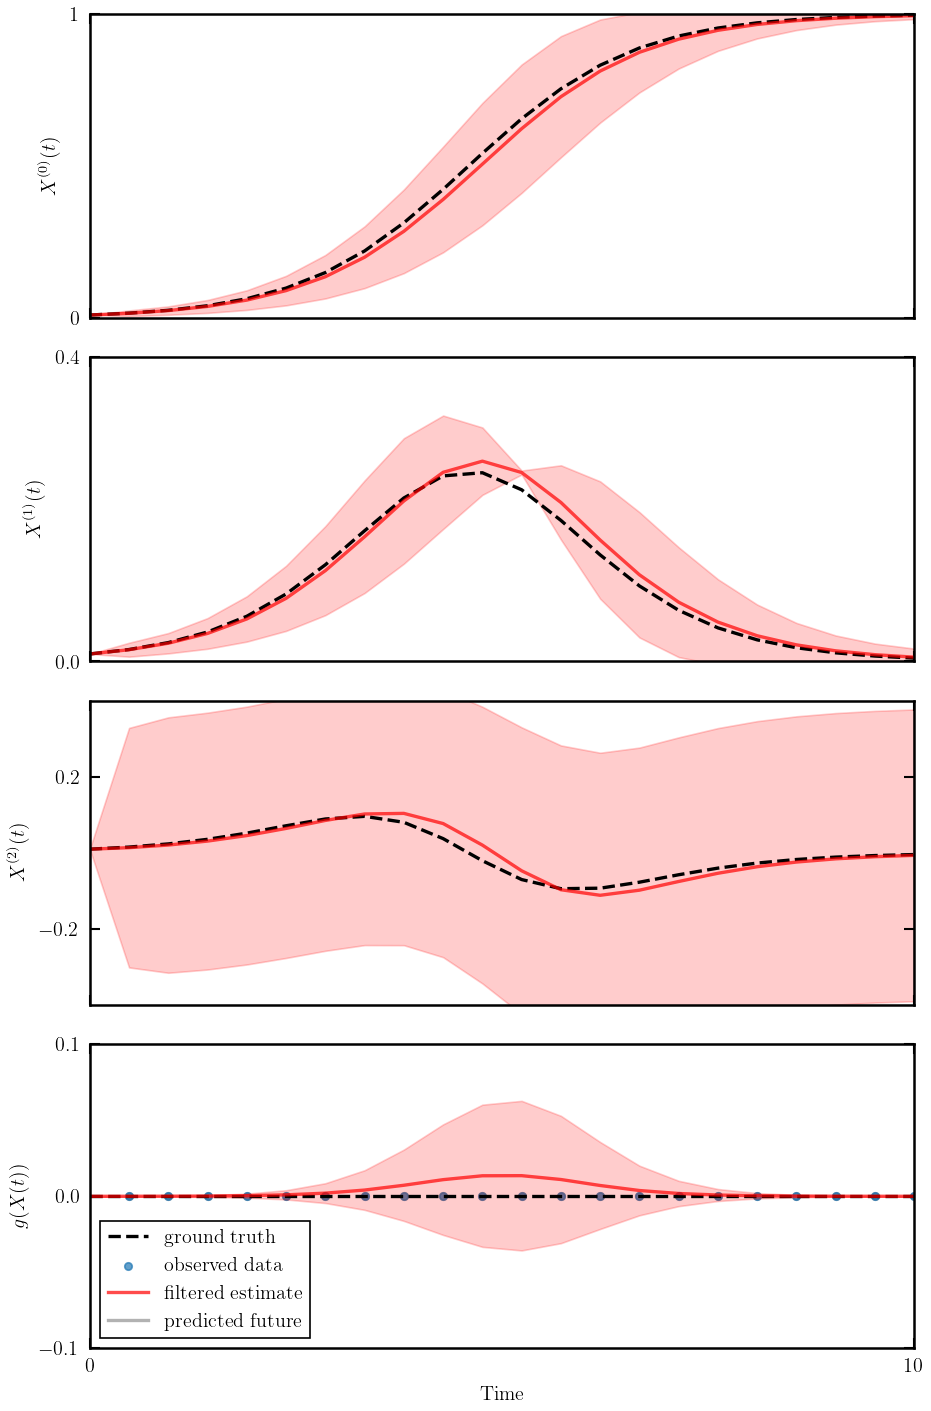

In [31]:
plot_kalman_filter_subplots(N-1)

In [32]:
for i in range(N):
    plot_kalman_filter_subplots(i, savefig=True)

(1,) (1,)
(1,) (1,)
(1,) (1,)
(1,) (1,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(3,) (3,)
(3,) (3,)
(3,) (3,)
(3,) (3,)
(4,) (4,)
(4,) (4,)
(4,) (4,)
(4,) (4,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(8,) (8,)
(8,) (8,)
(8,) (8,)
(8,) (8,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(11,) (11,)
(11,) (11,)
(11,) (11,)
(11,) (11,)
(12,) (12,)
(12,) (12,)
(12,) (12,)
(12,) (12,)
(13,) (13,)
(13,) (13,)
(13,) (13,)
(13,) (13,)
(14,) (14,)
(14,) (14,)
(14,) (14,)
(14,) (14,)
(15,) (15,)
(15,) (15,)
(15,) (15,)
(15,) (15,)
(16,) (16,)
(16,) (16,)
(16,) (16,)
(16,) (16,)
(17,) (17,)
(17,) (17,)
(17,) (17,)
(17,) (17,)
(18,) (18,)
(18,) (18,)
(18,) (18,)
(18,) (18,)
(19,) (19,)
(19,) (19,)
(19,) (19,)
(19,) (19,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(21,) (21,)
(21,) (21,)
(21,) (21,)
(21,) (21,)
(22,) (22,)
(22,) (22,)
(22,) (22,)
(22,) (22,)


In [ ]:
x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(4, 1, figsize=(4, 6))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])


    axs[i].set_xticks([0, 10])
    axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

axs[3].set_ylabel(f'$g(X(t))$')
axs[3].set_ylim(-2, 100)
axs[3].set_yticks([-2, 100])
axs[3].set_xlabel('$t$')
axs[3].set_xticks([0, 10])
axs[3].plot(ts, g(x1.T))
axs[3].plot(ts, g(x2.T))
axs[3].plot(ts, g(x3.T))
axs[3].plot(ts, g(x4.T))
axs[3].plot(ts, g(x5.T))
#plt.savefig('2-times-IWP.png')

In [ ]:
ts.shape

(10,)